# Pre-roll

In [265]:
import pandas as pd
import matplotlib.pyplot as plt
import cleaning_functions as cf

In [266]:
# define semester
SEMESTER = 'S2023'

# open file 
f = open(f"../logs/{SEMESTER}_raw_stats.txt", "w")

# Read in

In [267]:
raw_read_csv = f'../data/{SEMESTER}.csv'
clean_read_csv = f'../data/{SEMESTER}_cleaned.csv'
duplicate_types_csv = '../data/double_entry_type.csv'
duplicate_domain_csv = '../data/double_entry_domain.csv'
class_info_csv = '../data/ClassInfo.csv'

In [268]:
# load f2023 data
clean_df = pd.read_csv(clean_read_csv)

# load class data
class_df = pd.read_csv(class_info_csv)

In [269]:
# typecast column duration to timedelta
clean_df["Duration"] = pd.to_timedelta(clean_df["Duration"])

# typecast column date to datetime
clean_df["Start date"] = pd.to_datetime(clean_df["Start date"])
clean_df["End date"] = pd.to_datetime(clean_df["End date"])

print(clean_df.dtypes)

Unnamed: 0               int64
Client                  object
Project                 object
Description             object
Start date      datetime64[ns]
Start time              object
End date        datetime64[ns]
End time                object
Duration       timedelta64[ns]
Tags                    object
Type                    object
Domain                  object
dtype: object


In [270]:
# join the class info to the combined dataframe
combined_df = clean_df.merge(class_df, left_on = 'Project', right_on = 'Toggl Name')
combined_df = combined_df.reset_index(drop=True)

In [271]:
display(combined_df.head(5))
print(combined_df['Project'].unique())

,Unnamed: 0,Client,Project,Description,Start date,Start time,End date,End time,Duration,Tags,Type,Domain,Semester,Year,Professor,Department Code,Department Number,Class Name,Toggl Name
0,0,S2023,Chemistry 1,Intro Survey,2023-01-10,14:00:47,2023-01-10,14:24:46,0 days 00:23:59,Domain: School,Not Specified,Not Specified,Spring,2023,Renee Falconer,CHGN,121,Principles of Chemistry I,Chemistry 1
1,11,S2023,Chemistry 1,Math Review Mastering,2023-01-17,14:21:28,2023-01-17,14:44:30,0 days 00:23:02,Domain: School,Not Specified,Not Specified,Spring,2023,Renee Falconer,CHGN,121,Principles of Chemistry I,Chemistry 1
2,14,S2023,Chemistry 1,Chapter 1 Mastering,2023-01-17,21:05:00,2023-01-17,21:33:00,0 days 00:28:00,Domain: School,Not Specified,Not Specified,Spring,2023,Renee Falconer,CHGN,121,Principles of Chemistry I,Chemistry 1
3,16,S2023,Chemistry 1,Excel Lab (Snow Day),2023-01-18,10:17:40,2023-01-18,10:31:27,0 days 00:13:47,Domain: School,Not Specified,Not Specified,Spring,2023,Renee Falconer,CHGN,121,Principles of Chemistry I,Chemistry 1
4,18,S2023,Chemistry 1,Chapter 1 Mastering,2023-01-18,19:13:18,2023-01-18,19:49:23,0 days 00:36:05,Domain: School,Not Specified,Not Specified,Spring,2023,Renee Falconer,CHGN,121,Principles of Chemistry I,Chemistry 1


['Chemistry 1' 'Computer Organization' 'Database Management'
 'ExpModernWorld' 'Music Technology']


# Analysis

### Analysis Pre-Roll

In [272]:
# constant variables
COLOR = 'skyblue'
ROTATION = 15

# plt specifics
plt.style.use('seaborn-notebook')
plt.rcParams['figure.figsize'] = (14, 6)

font = {'family': 'sans-serif', 
        'style': 'normal', 
        'weight': 'bold', 
        'size': 15}
plt.rc('font', **font)

def print_plot(total_time_df, class_df, course, save=False):
    bars = plt.bar(total_time_df[total_time_df['Project'] == course]['Type'], 
                   total_time_df[total_time_df['Project'] == course]['Duration'], 
                   color=COLOR, width=0.4)
    
    plt.xlabel("Type", size=14)
    plt.xticks(rotation=ROTATION)
    plt.ylabel("Time (hours)", size=14)
    plt.title(f"Time Investment per Type of Work for {class_df[class_df['Toggl Name'] == course]['Class Name'].iloc[0]}"
              f" ({class_df[class_df['Toggl Name'] == course]['Department Code'].iloc[0]}{class_df[class_df['Toggl Name'] == course]['Department Number'].iloc[0]})"
              f" {SEMESTER}"
              f"\nTotal Time: {total_time_df[total_time_df['Project'] == course]['Duration'].sum():.2f} hours", size=18)

    for bar in bars:
        hours = int(bar.get_height())
        minutes = int((bar.get_height() - hours) * 60)
        label = f"{hours}h {minutes}m"
        plt.text(bar.get_x() + bar.get_width() / 2.0, bar.get_height(), label, ha='center', va='bottom')


    # Save plot
    if save:
        course = course.replace(" ", "-")
        plt.savefig(f"../images/course_{course}_{SEMESTER}.png", transparent=False, format='png', dpi=300)

    plt.show()

# stat print function
def calc_stats(total_time_df, course, filepath = None):
    # calculate percentages of time spent on each type of work
    total_time_df = total_time_df[total_time_df['Project'] == course]
    total_time = total_time_df['Duration'].sum()
    type_time_dict = {ty:total_time_df.loc[total_time_df['Type'] == ty, 'Duration'].sum() for ty in total_time_df['Type'].unique()}
    type_time_dict = {k: v for k, v in sorted(type_time_dict.items(), key=lambda item: item[1], reverse = True)}

    # printing statistics
    print_string = [f"COURSE: {class_df[class_df['Toggl Name'] == course]['Class Name'].iloc[0]}"
              f" ({class_df[class_df['Toggl Name'] == course]['Department Code'].iloc[0]}{class_df[class_df['Toggl Name'] == course]['Department Number'].iloc[0]})"
              f" {SEMESTER}"]
    for ty in type_time_dict:
        type_time_dict[ty] = type_time_dict[ty] / total_time * 100
        type_total_time = total_time_df[total_time_df['Type'] == ty]['Duration'].sum()

        # find total hours spent on ty type 
        print_string.append(f"{ty}: {type_total_time:.2f} hours ({type_time_dict[ty]:.2f}%)")
    print_string.append(f"TOTAL TIME : {total_time:.2f} hours")

    # save statistics
    if filepath is not None:
        f.write("\n".join(print_string) + "\n\n")

    return "\n".join(print_string)

def calc_hours_per_credit(total_time_df, course, filepath = None, hours = 3, weeks = 16):
    # calculate hours per credit
    total_time_df = total_time_df[total_time_df['Project'] == course]
    total_time = total_time_df['Duration'].sum()
    hours = total_time_df['Credits'].iloc[0]

    # printing statistics
    print_string = [f"COURSE: {class_df[class_df['Toggl Name'] == course]['Class Name'].iloc[0]}"
              f" ({class_df[class_df['Toggl Name'] == course]['Department Code'].iloc[0]}{class_df[class_df['Toggl Name'] == course]['Department Number'].iloc[0]})"
              f" {SEMESTER}"]
    
    print_string.append(f"TOTAL TIME : {total_time:.2f} hours")
    print_string.append(f"HOURS PER WEEK : {total_time / weeks:.2f} hours")
    print_string.append(f"HOURS PER CREDIT PER WEEK : {total_time / (hours * weeks):.2f} hours")

    # save statistics
    if filepath is not None:
        f.write("\n".join(print_string) + "\n\n")

    return "\n".join(print_string)

### Analysis for All Courses

In [273]:
# create a new dataframe with the total time per project
total_time_df = combined_df.groupby(['Project', 'Type', 'Class Name', 'Credits'], as_index=False)['Duration'].sum()

# sort by duration
total_time_df = total_time_df.sort_values(by=['Duration'], ascending=False)

# keep only the projects with valid names
total_time_df = total_time_df.loc[total_time_df['Project'].isin(class_df['Toggl Name'])]

# convert the duration column to hours 
total_time_df['Duration'] = total_time_df['Duration'].dt.total_seconds() / 3600

# find the total time
total_time = total_time_df['Duration'].sum()

In [274]:
display(total_time_df.head(5))

,Project,Type,Class Name,Duration
3,ExpModernWorld,Not Specified,Explorations in Modern World,47.412500
4,Music Technology,Not Specified,Music Technology,33.788889
0,Chemistry 1,Not Specified,Principles of Chemistry I,33.674167
2,Database Management,Not Specified,Database Management,33.571111
1,Computer Organization,Not Specified,Computer Organization,29.202778


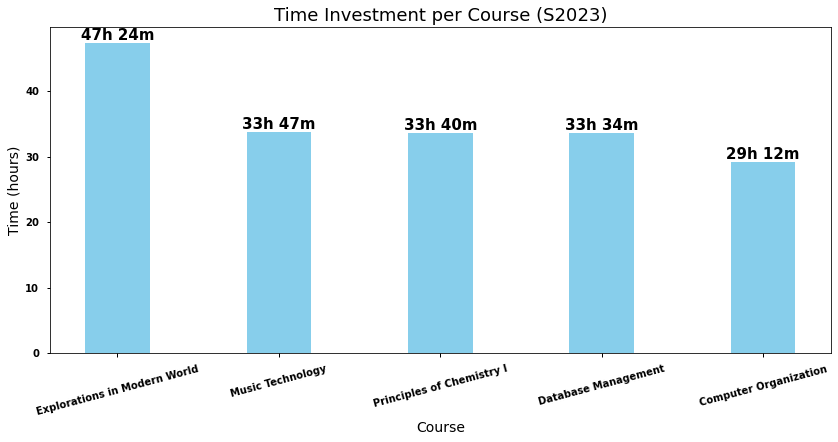

Computer Organization: 29.20 hours (16.44%)
ExpModernWorld: 47.41 hours (26.69%)
Chemistry 1: 33.67 hours (18.96%)
Database Management: 33.57 hours (18.90%)
Music Technology: 33.79 hours (19.02%)
TOTAL TIME : 177.65 hours


In [275]:
# group data
aggregated_data = total_time_df.groupby('Class Name')['Duration'].sum().reset_index()
aggregated_data = aggregated_data.sort_values(by=['Duration'], ascending=False)

# plot data
bars = plt.bar(aggregated_data['Class Name'], aggregated_data['Duration'], color = COLOR, 
        width = 0.4)
plt.xlabel("Course", size = 14)
plt.xticks(rotation=ROTATION)
plt.ylabel("Time (hours)", size = 14)
plt.title(f"Time Investment per Course ({SEMESTER})", size = 18)
# Add labels to each bar
for bar in bars:
    hours = int(bar.get_height())
    minutes = int((bar.get_height() - hours) * 60)
    label = f"{hours}h {minutes}m"
    plt.text(bar.get_x() + bar.get_width() / 2.0, bar.get_height(), label, ha='center', va='bottom')

plt.savefig(f"../images/{SEMESTER}_per_course.png", transparent=False, format = 'png', dpi = 300)
plt.show()

# write data
print_string = []
for course in set(total_time_df['Project']):
    course_total_time = total_time_df[total_time_df['Project'] == course]['Duration'].sum()
    print_string.append(f"{course}: {course_total_time:.2f} hours ({(course_total_time / total_time * 100):.2f}%)")
print_string.append("TOTAL TIME : {:.2f} hours".format(total_time))
print("\n".join(print_string))
    


Not Specified: 177.65 hours (100.00%)
TOTAL TIME : 177.65 hours


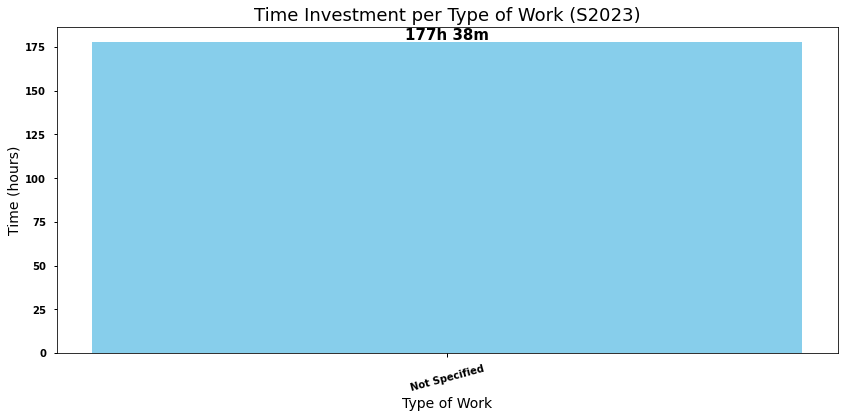

In [276]:
# group data
aggregated_data = total_time_df.groupby('Type')['Duration'].sum().reset_index()
aggregated_data = aggregated_data.sort_values(by=['Duration'], ascending=False)

# plot data
bars =plt.bar(aggregated_data['Type'], aggregated_data['Duration'], color = COLOR, 
        width = 0.4)
plt.xlabel("Type of Work", size = 14)
plt.ylabel("Time (hours)", size = 14)
plt.xticks(rotation=ROTATION)
plt.title(f"Time Investment per Type of Work ({SEMESTER})", size = 18)
for bar in bars:
        hours = int(bar.get_height())
        minutes = int((bar.get_height() - hours) * 60)
        label = f"{hours}h {minutes}m"
        plt.text(bar.get_x() + bar.get_width() / 2.0, bar.get_height(), label, ha='center', va='bottom')
plt.savefig(f"../images/{SEMESTER}_per_type.png", transparent=False, format = 'png', dpi = 300)

# calculate percentages of time spent on each type of work
type_time_dict = {ty:total_time_df.loc[total_time_df['Type'] == ty, 'Duration'].sum() for ty in total_time_df['Type'].unique()}
type_time_dict = {k: v for k, v in sorted(type_time_dict.items(), key=lambda item: item[1], reverse = True)}

# printing statistics
print_string = []
for ty in type_time_dict:
    type_time_dict[ty] = type_time_dict[ty] / total_time * 100
    type_total_time = total_time_df[total_time_df['Type'] == ty]['Duration'].sum()
    print_string.append(f"{ty}: {type_total_time:.2f} hours ({type_time_dict[ty]:.2f}%)")
print_string.append("TOTAL TIME : {:.2f} hours".format(total_time))
print("\n".join(print_string))


### Analysis for Individual Courses

Computer Organization


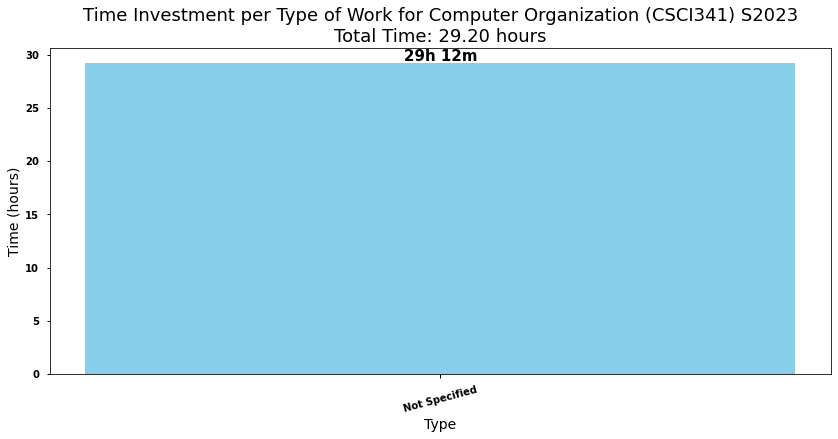

COURSE: Computer Organization (CSCI341) S2023
Not Specified: 29.20 hours (100.00%)
TOTAL TIME : 29.20 hours

COURSE: Computer Organization (CSCI341) S2023
TOTAL TIME : 29.20 hours
HOURS PER WEEK : 1.83 hours
HOURS PER CREDIT PER WEEK : 0.61 hours
ExpModernWorld


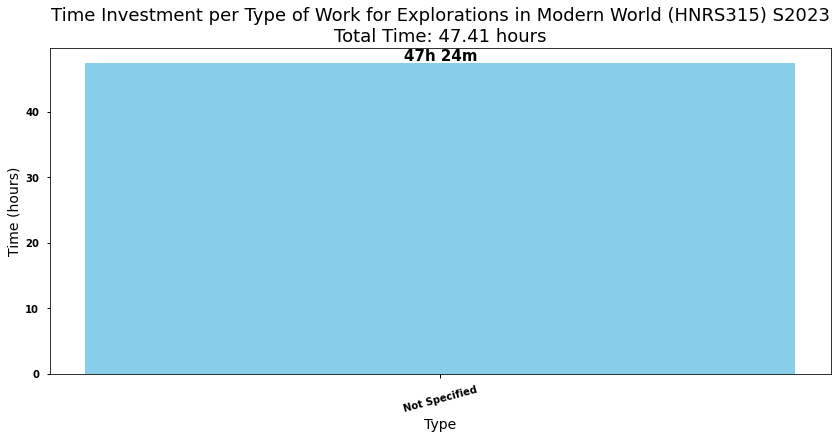

COURSE: Explorations in Modern World (HNRS315) S2023
Not Specified: 47.41 hours (100.00%)
TOTAL TIME : 47.41 hours

COURSE: Explorations in Modern World (HNRS315) S2023
TOTAL TIME : 47.41 hours
HOURS PER WEEK : 2.96 hours
HOURS PER CREDIT PER WEEK : 0.99 hours
Chemistry 1


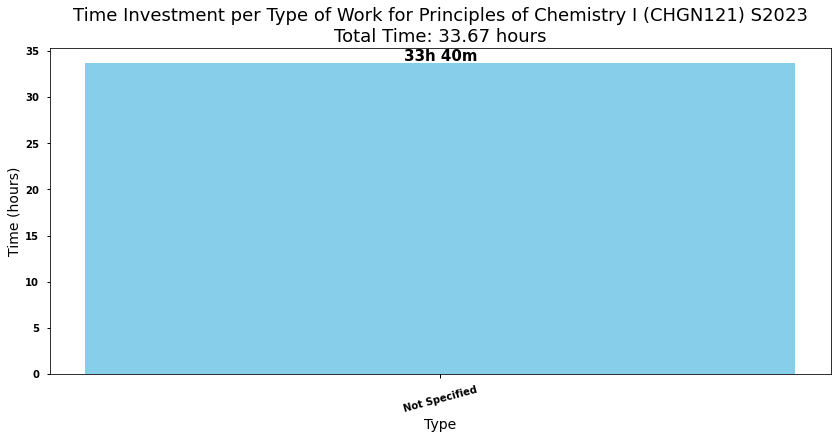

COURSE: Principles of Chemistry I (CHGN121) S2023
Not Specified: 33.67 hours (100.00%)
TOTAL TIME : 33.67 hours

COURSE: Principles of Chemistry I (CHGN121) S2023
TOTAL TIME : 33.67 hours
HOURS PER WEEK : 2.10 hours
HOURS PER CREDIT PER WEEK : 0.70 hours
Database Management


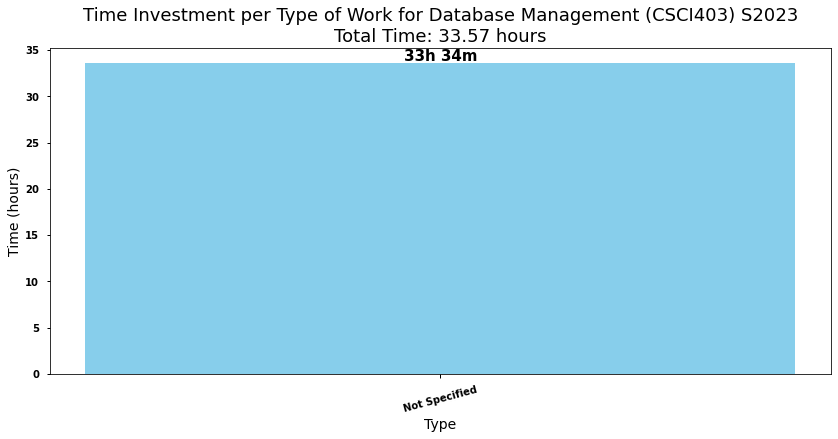

COURSE: Database Management (CSCI403) S2023
Not Specified: 33.57 hours (100.00%)
TOTAL TIME : 33.57 hours

COURSE: Database Management (CSCI403) S2023
TOTAL TIME : 33.57 hours
HOURS PER WEEK : 2.10 hours
HOURS PER CREDIT PER WEEK : 0.70 hours
Music Technology


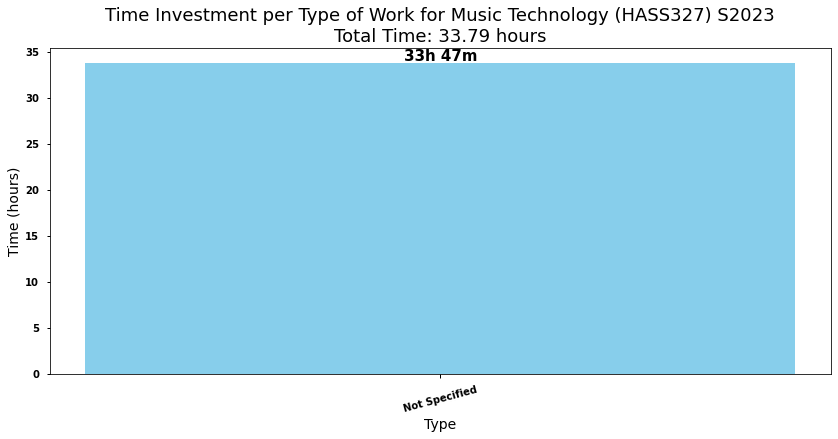

COURSE: Music Technology (HASS327) S2023
Not Specified: 33.79 hours (100.00%)
TOTAL TIME : 33.79 hours

COURSE: Music Technology (HASS327) S2023
TOTAL TIME : 33.79 hours
HOURS PER WEEK : 2.11 hours
HOURS PER CREDIT PER WEEK : 0.70 hours


In [277]:
for course in set(total_time_df['Project']):
    print(course)
    print_plot(total_time_df, class_df, course, save = True)
    print(calc_stats(total_time_df, course, f) + "\n")
    print(calc_hours_per_credit(total_time_df, course, filepath=f))

# Time per Day

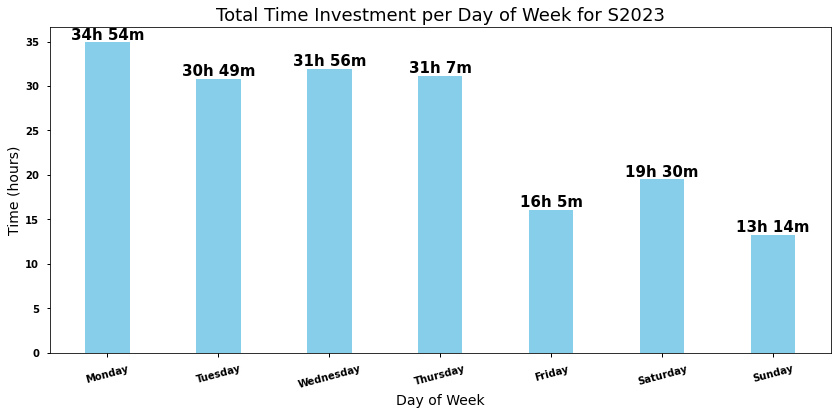

In [278]:
# using combined_df, find time spent per day of week 
combined_df['Day of Week'] = combined_df['Start date'].dt.day_name()
day_of_week_df = combined_df.groupby(['Day of Week'], as_index=False)['Duration'].sum()

# convert the duration column to hours
day_of_week_df['Duration'] = day_of_week_df['Duration'].dt.total_seconds() / 3600
day_of_week_df.head(5)

# create a column that matches Monday to 0, Tuesday to 1, etc.
day_of_week_df['Day Value'] = day_of_week_df['Day of Week'].map({'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 
                                                                   'Thursday': 3, 'Friday': 4, 'Saturday': 5, 
                                                                   'Sunday': 6})
day_of_week_df = day_of_week_df.sort_values(by=['Day Value'])

# create a bar graph of time spent per day of week in order of day of week
bars = plt.bar(day_of_week_df['Day of Week'], day_of_week_df['Duration'], color = COLOR, 
        width = 0.4)
plt.xlabel("Day of Week", size = 14)
plt.ylabel("Time (hours)", size = 14)
plt.xticks(rotation=ROTATION)
plt.title(f"Total Time Investment per Day of Week for {SEMESTER}", size = 18)
for bar in bars:
        hours = int(bar.get_height())
        minutes = int((bar.get_height() - hours) * 60)
        label = f"{hours}h {minutes}m"
        plt.text(bar.get_x() + bar.get_width() / 2.0, bar.get_height(), label, ha='center', va='bottom')
plt.savefig(f"../images/{SEMESTER}_per_day.png", transparent=False, format = 'png', dpi=300)
plt.show()

# Post Roll 

In [279]:
f.close()